In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence

import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from tqdm import tqdm

2024-04-26 18:54:07.528721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 18:54:07.528818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 18:54:07.654398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if GPU is available or not

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [3]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


In [4]:
parameters = {}
parameters['number_of_users_in_total'] = len(users_sequences)
parameters['number_of_sequences_in_total'] = len(users_sequences)

#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [5]:
min_num_of_products_in_sequence = 5
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 252156


In [6]:
parameters['number_of_sequences_after_filtering'] = len(filtered_users_sequences)
parameters['number_of_users_after_filtering'] = len(filtered_users_sequences)

#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [7]:
sequence_length = 5

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

In [8]:
parameters['sequence_length'] = sequence_length

#### Assigning obtained datasets to a clearer form

In [9]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 12441], [0, 0, 0, 12441, 47820], [0, 0, 12441, 47820, 114530], [0, 12441, 47820, 114530, 86657], [12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 11424], [0, 0, 0, 11424, 5089], [0, 0, 11424, 5089, 108533], [0, 11424, 5089, 108533, 108535], [11424, 5089, 108533, 108535, 22344]]

Targets:
 [47820, 114530, 86657, 39579, 91113, 5089, 108533, 108535, 22344, 18742]


In [10]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1489192
Number of validation sequences: 252156
Number of test sequences: 252156

Number of train targets: 1489192
Number of validation targets: 252156
Number of test targets: 252156


In [11]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

#### Preprocessing datasets for faster processing

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### F1@k

In [15]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [16]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [17]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [18]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

-------

# Training and evaluating models

## LSTM

In [20]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [21]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   13/23269 ━━━━━━━━━━━━━━━━━━━━ 3:26 9ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 6.3950e-04 - hit_rate_at_k: 0.0022 - loss: 11.8808 - ndcg_at_k: 4.3764e-04       

I0000 00:00:1714146070.980532     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 215s 9ms/step - accuracy: 0.0321 - f1_score_at_k: 0.0032 - hit_rate_at_k: 0.0184 - loss: 9.6721 - ndcg_at_k: 0.0044 - val_accuracy: 0.0491 - val_f1_score_at_k: 0.0064 - val_hit_rate_at_k: 0.0126 - val_loss: 9.6015 - val_ndcg_at_k: 0.0027
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - accuracy: 0.0551 - f1_score_at_k: 0.0047 - hit_rate_at_k: 0.0163 - loss: 9.0393 - ndcg_at_k: 0.0036 - val_accuracy: 0.0638 - val_f1_score_at_k: 0.0073 - val_hit_rate_at_k: 0.0124 - val_loss: 9.4618 - val_ndcg_at_k: 0.0027
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 194s 8ms/step - accuracy: 0.0656 - f1_score_at_k: 0.0054 - hit_rate_at_k: 0.0161 - loss: 8.8444 - ndcg_at_k: 0.0036 - val_accuracy: 0.0695 - val_f1_score_at_k: 0.0078 - val_hit_rate_at_k: 0.0127 - val_loss: 9.4129 - val_ndcg_at_k: 0.0027
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 190s 8ms/step - accuracy: 0.0713 - f1_score_at_k: 0.0058 - hit_rate_at_k: 0.0159 - loss: 8.7434 - ndcg_at_k: 0.0036 - val

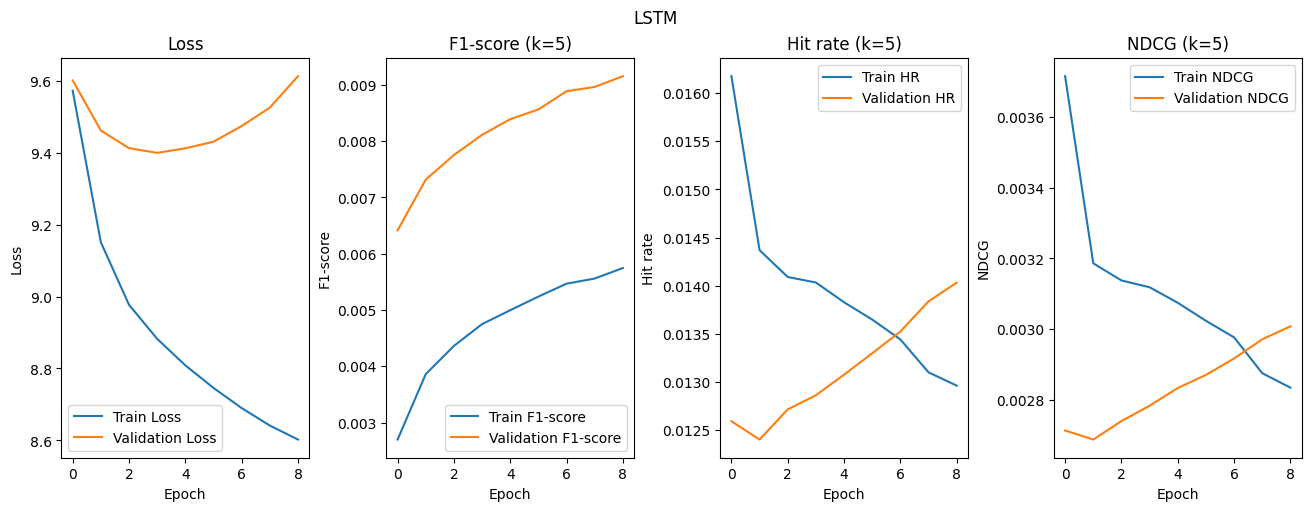

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('LSTM')
plt.show()

In [27]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score"] = round(model_lstm_test_f1_score, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.0768 - f1_score_at_k: 0.0103 - hit_rate_at_k: 0.0138 - loss: nan - ndcg_at_k: 0.0029
Test loss: nan
Test accuracy: 0.0613
Test F1@5: 0.007
Test HR@5: 0.0101
Test NDCG@5: 0.0022


In [28]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 5,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0613,
 'model_lstm_test_f1_score': 0.007,
 'model_lstm_test_hr': 0.0101,
 'model_lstm_test_ndcg': 0.0022}

---------

## Bidirectional-LSTM

In [29]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [30]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 273s 11ms/step - accuracy: 0.0411 - f1_score_at_k: 0.0037 - hit_rate_at_k: 0.0179 - loss: 9.6306 - ndcg_at_k: 0.0042 - val_accuracy: 0.0606 - val_f1_score_at_k: 0.0071 - val_hit_rate_at_k: 0.0126 - val_loss: 9.5142 - val_ndcg_at_k: 0.0028
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 253s 11ms/step - accuracy: 0.0681 - f1_score_at_k: 0.0055 - hit_rate_at_k: 0.0170 - loss: 8.9451 - ndcg_at_k: 0.0039 - val_accuracy: 0.0728 - val_f1_score_at_k: 0.0079 - val_hit_rate_at_k: 0.0132 - val_loss: 9.4152 - val_ndcg_at_k: 0.0029
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 256s 11ms/step - accuracy: 0.0790 - f1_score_at_k: 0.0062 - hit_rate_at_k: 0.0171 - loss: 8.7671 - ndcg_at_k: 0.0038 - val_accuracy: 0.0782 - val_f1_score_at_k: 0.0084 - val_hit_rate_at_k: 0.0134 - val_loss: 9.3739 - val_ndcg_at_k: 0.0029
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 253s 11ms/step - accuracy: 0.0849 - f1_score_at_k: 0.0065 - hit_rate_at_k: 0.0165 - loss: 8.6677 - ndcg_at_

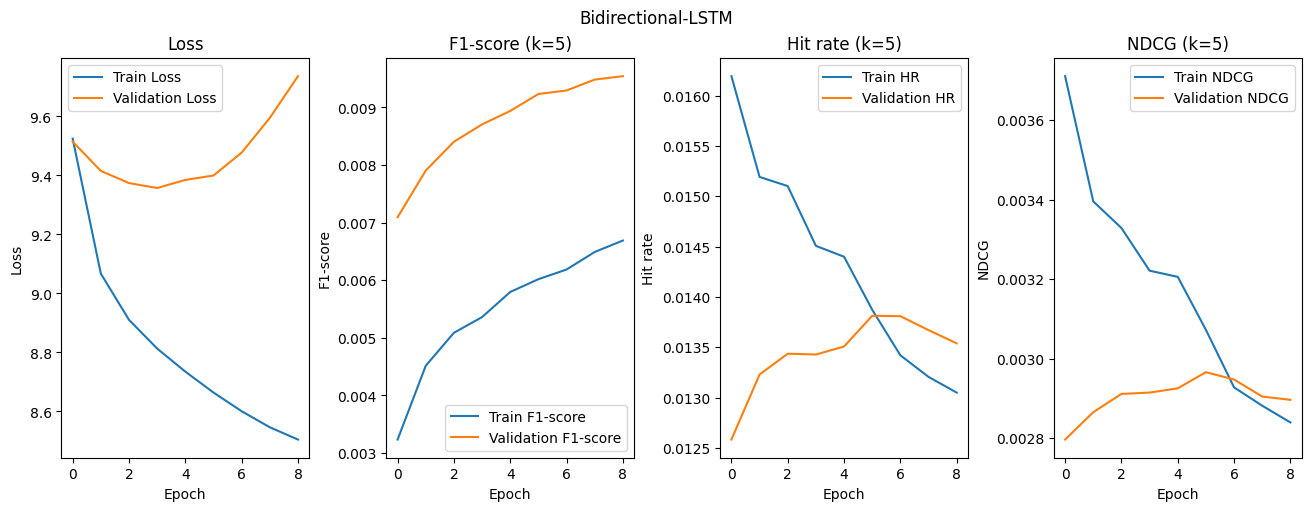

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [32]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score"] = round(model_bi_lstm_test_f1_score, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0836 - f1_score_at_k: 0.0108 - hit_rate_at_k: 0.0138 - loss: nan - ndcg_at_k: 0.0029
Test loss: nan
Test accuracy: 0.0677
Test F1@5: 0.0074
Test HR@5: 0.01
Test NDCG@5: 0.0021


In [33]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 5,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0613,
 'model_lstm_test_f1_score': 0.007,
 'model_lstm_test_hr': 0.0101,
 'model_lstm_test_ndcg': 0.0022,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0677,
 'model_bi_lstm_test_f1_score': 0.0074,
 'model_bi_lstm_test_hr': 0.01,
 'model_bi_lstm_test_ndcg': 0.0021}

-----------

## GRU

In [19]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [20]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   14/23269 ━━━━━━━━━━━━━━━━━━━━ 3:12 8ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 3.8933e-04 - hit_rate_at_k: 0.0016 - loss: 11.8810 - ndcg_at_k: 4.2102e-04       

I0000 00:00:1714157745.160110     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 207s 8ms/step - accuracy: 0.0344 - f1_score_at_k: 0.0034 - hit_rate_at_k: 0.0176 - loss: 9.6776 - ndcg_at_k: 0.0043 - val_accuracy: 0.0537 - val_f1_score_at_k: 0.0067 - val_hit_rate_at_k: 0.0125 - val_loss: 9.5590 - val_ndcg_at_k: 0.0027
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 186s 8ms/step - accuracy: 0.0564 - f1_score_at_k: 0.0048 - hit_rate_at_k: 0.0166 - loss: 9.0361 - ndcg_at_k: 0.0037 - val_accuracy: 0.0631 - val_f1_score_at_k: 0.0072 - val_hit_rate_at_k: 0.0124 - val_loss: 9.4758 - val_ndcg_at_k: 0.0027
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 186s 8ms/step - accuracy: 0.0632 - f1_score_at_k: 0.0051 - hit_rate_at_k: 0.0160 - loss: 8.8706 - ndcg_at_k: 0.0036 - val_accuracy: 0.0680 - val_f1_score_at_k: 0.0077 - val_hit_rate_at_k: 0.0126 - val_loss: 9.4188 - val_ndcg_at_k: 0.0027
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 190s 8ms/step - accuracy: 0.0679 - f1_score_at_k: 0.0056 - hit_rate_at_k: 0.0161 - loss: 8.7829 - ndcg_at_k: 0.0036 - val

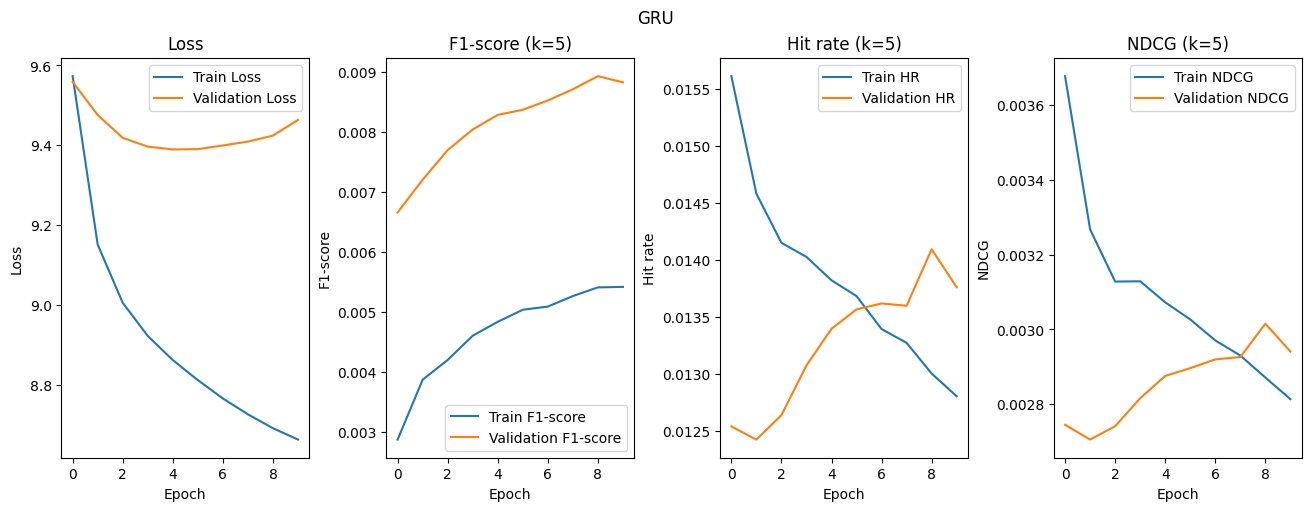

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('GRU')
plt.show()

In [22]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@5:", round(model_gru_test_f1_score, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score"] = round(model_gru_test_f1_score, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.0764 - f1_score_at_k: 0.0103 - hit_rate_at_k: 0.0140 - loss: nan - ndcg_at_k: 0.0030
Test loss: nan
Test accuracy: 0.0612
Test F1@5: 0.0069
Test HR@5: 0.01
Test NDCG@5: 0.0021


In [23]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 5,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0612,
 'model_gru_test_f1_score': 0.0069,
 'model_gru_test_hr': 0.01,
 'model_gru_test_ndcg': 0.0021}

--------

## Autoencoder

In [24]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [25]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 220s 9ms/step - accuracy: 0.0261 - f1_score_at_k: 0.0178 - hit_rate_at_k: 0.0478 - loss: 9.8047 - ndcg_at_k: 0.0126 - val_accuracy: 0.0383 - val_f1_score_at_k: 0.0503 - val_hit_rate_at_k: 0.0660 - val_loss: 9.3981 - val_ndcg_at_k: 0.0180
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step - accuracy: 0.0426 - f1_score_at_k: 0.0459 - hit_rate_at_k: 0.0786 - loss: 8.9592 - ndcg_at_k: 0.0208 - val_accuracy: 0.0508 - val_f1_score_at_k: 0.0637 - val_hit_rate_at_k: 0.0804 - val_loss: 9.2988 - val_ndcg_at_k: 0.0225
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step - accuracy: 0.0502 - f1_score_at_k: 0.0566 - hit_rate_at_k: 0.0891 - loss: 8.8641 - ndcg_at_k: 0.0239 - val_accuracy: 0.0596 - val_f1_score_at_k: 0.0687 - val_hit_rate_at_k: 0.0866 - val_loss: 9.3474 - val_ndcg_at_k: 0.0250
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step - accuracy: 0.0545 - f1_score_at_k: 0.0619 - hit_rate_at_k: 0.0952 - loss: 8.8163 - ndcg_at_k: 0

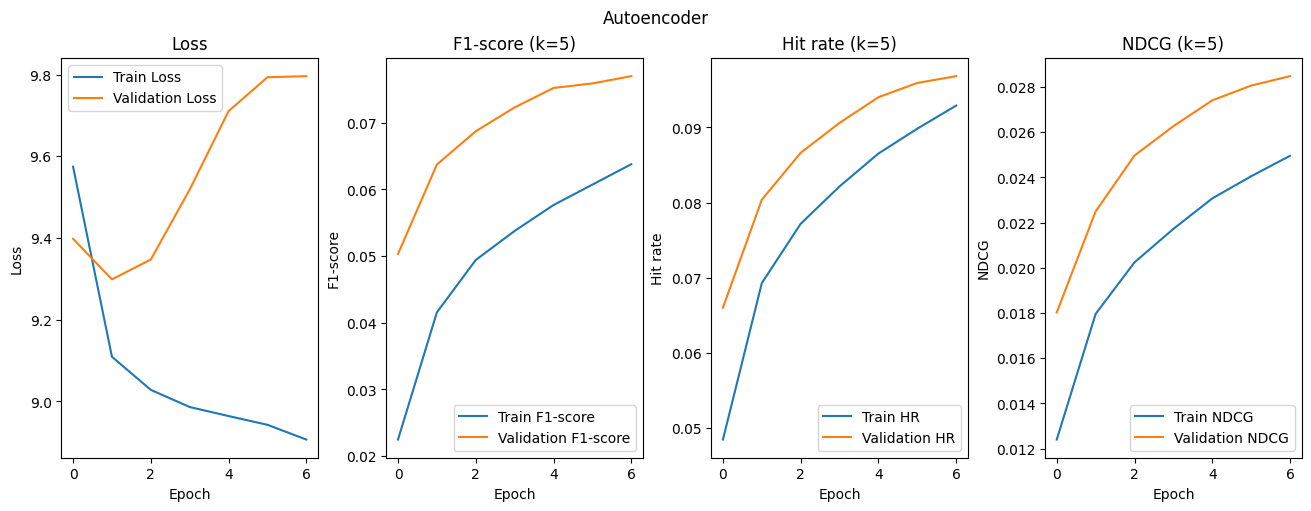

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Autoencoder')
plt.show()

In [27]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score"] = round(model_autoencoder_test_f1_score, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0630 - f1_score_at_k: 0.0728 - hit_rate_at_k: 0.0864 - loss: nan - ndcg_at_k: 0.0255
Test loss: nan
Test accuracy: 0.0491
Test F1@5: 0.0581
Test HR@5: 0.0702
Test NDCG@5: 0.0204


In [28]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 5,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0612,
 'model_gru_test_f1_score': 0.0069,
 'model_gru_test_hr': 0.01,
 'model_gru_test_ndcg': 0.0021,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0491,
 'model_autoencoder_test_f1_score': 0.0581,
 'model_autoencoder_test_hr': 0.0702,
 'model_autoencoder_test_ndcg': 0.0204}

-------

## CNN

In [29]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
#model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(max_product_id, activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [30]:
history_model_cnn = model_cnn.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 176s 7ms/step - accuracy: 0.0413 - f1_score_at_k: 0.0359 - hit_rate_at_k: 0.0643 - loss: 9.5968 - ndcg_at_k: 0.0181 - val_accuracy: 0.0585 - val_f1_score_at_k: 0.0605 - val_hit_rate_at_k: 0.0744 - val_loss: 9.5837 - val_ndcg_at_k: 0.0228
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 162s 7ms/step - accuracy: 0.0686 - f1_score_at_k: 0.0682 - hit_rate_at_k: 0.0963 - loss: 8.9713 - ndcg_at_k: 0.0282 - val_accuracy: 0.0679 - val_f1_score_at_k: 0.0696 - val_hit_rate_at_k: 0.0844 - val_loss: 9.4817 - val_ndcg_at_k: 0.0260
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 162s 7ms/step - accuracy: 0.0782 - f1_score_at_k: 0.0770 - hit_rate_at_k: 0.1058 - loss: 8.7879 - ndcg_at_k: 0.0315 - val_accuracy: 0.0737 - val_f1_score_at_k: 0.0733 - val_hit_rate_at_k: 0.0901 - val_loss: 9.4321 - val_ndcg_at_k: 0.0280
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 163s 7ms/step - accuracy: 0.0841 - f1_score_at_k: 0.0808 - hit_rate_at_k: 0.1113 - loss: 8.6812 - ndcg_at_k: 0

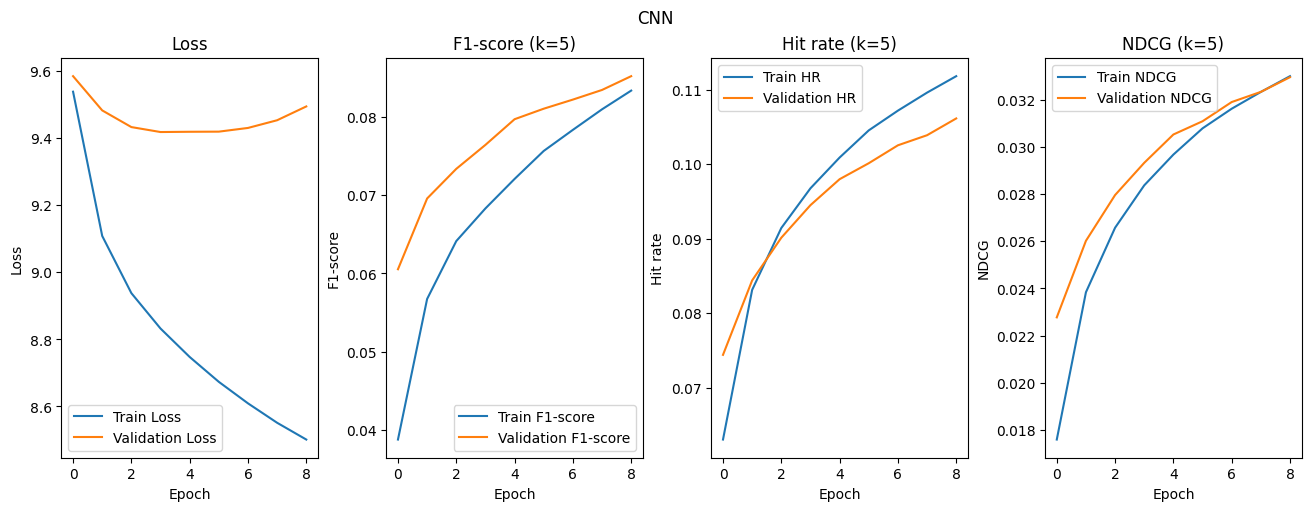

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_cnn.history['loss'], label='Train Loss')
ax1.plot(history_model_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_cnn.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_cnn.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_cnn.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_cnn.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_cnn.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_cnn.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('CNN')
plt.show()

In [32]:
model_cnn_test_loss, model_cnn_test_accuracy, model_cnn_test_f1_score, model_cnn_test_hr, model_cnn_test_ndcg = model_cnn.evaluate(test_dataset)

print("Test loss:", round(model_cnn_test_loss, 4))
print("Test accuracy:", round(model_cnn_test_accuracy, 4))
print("Test F1@5:", round(model_cnn_test_f1_score, 4))
print("Test HR@5:", round(model_cnn_test_hr, 4))
print("Test NDCG@5:", round(model_cnn_test_ndcg, 4))

parameters["model_cnn_test_loss"] = model_cnn_test_loss
parameters["model_cnn_test_accuracy"] = round(model_cnn_test_accuracy, 4)
parameters["model_cnn_test_f1_score"] = round(model_cnn_test_f1_score, 4)
parameters["model_cnn_test_hr"] = round(model_cnn_test_hr, 4)
parameters["model_cnn_test_ndcg"] = round(model_cnn_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.0799 - f1_score_at_k: 0.0788 - hit_rate_at_k: 0.0951 - loss: nan - ndcg_at_k: 0.0298
Test loss: nan
Test accuracy: 0.0644
Test F1@5: 0.0642
Test HR@5: 0.0786
Test NDCG@5: 0.0244


------

In [34]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 5,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0612,
 'model_gru_test_f1_score': 0.0069,
 'model_gru_test_hr': 0.01,
 'model_gru_test_ndcg': 0.0021,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0491,
 'model_autoencoder_test_f1_score': 0.0581,
 'model_autoencoder_test_hr': 0.0702,
 'model_autoencoder_test_ndcg': 0.0204,
 'model_cnn_test_loss': nan,
 'model_cnn_test_accuracy': 0.0644,
 'model_cnn_test_f1_score': 0.0642,
 'model_cnn_test_hr': 0.0786,
 'model_cnn_test_ndcg': 0.0244}